In [1]:
"""!pip install nlpaug
!pip3 install nltk
!pip install transformers
!pip install --upgrade tensorflow
!pip install --upgrade sentencepiece
!pip install transformers[sentencepiece]"""

'!pip install nlpaug\n!pip3 install nltk\n!pip install transformers\n!pip install --upgrade tensorflow\n!pip install --upgrade sentencepiece\n!pip install transformers[sentencepiece]'

In [ ]:
%load_ext autoreload
%autoreload 2
import importlib

In [ ]:
import os
os.environ["MODEL_DIR"] = '../model'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from ast import literal_eval

#import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
#import nlpaug.augmenter.sentence as nas
#import nlpaug.flow as nafc
#from nlpaug.util import Action

import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.


In [ ]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
DATA_ROOT_DIR = os.path.join("..", "..", "..", "data", "frameworks_data", "data_v0.4.4")
TRAIN_PATH = os.path.join("data_v0.4.4_train.csv")
VAL_PATH = os.path.join("data_v0.4.4_val.csv")

In [ ]:
train_dataset = pd.read_csv(TRAIN_PATH)
val_dataset = pd.read_csv(VAL_PATH)

In [ ]:
def clean_rows (row):
    """
    1) Apply litteral evaluation
    2) Drop values that are repeated multiple times in rows
    """
    return list(set(literal_eval(row)))

In [ ]:
train_dataset = pd.read_csv(TRAIN_PATH)
val_dataset = pd.read_csv(VAL_PATH)

all_dataset = pd.concat([train_dataset, val_dataset])

# Keep only unique values in pillars
all_dataset["pillars"] = all_dataset["pillars"].apply(lambda x: clean_rows (x))
all_dataset["subpillars"] = all_dataset["subpillars"].apply(lambda x: clean_rows (x))

# Keep only rows with a not empty pillar
all_dataset = all_dataset[all_dataset.pillars.apply(lambda x: len(x)>0)]

In [ ]:
all_dataset.head()

,Unnamed: 0,entry_id,lead_id,project_id,project_title,analysis_framework_id,excerpt,dropped_excerpt,created_by_id,modified_by_id,verified,verification_last_changed_by_id,language,sectors,pillars,subpillars
0,0,163664,35315,2028,IMMAP/DFS Syria,1306,Market monitoring by the World Food Programme ...,NaN,2232,2232,False,NaN,en,['Food Security'],[Impact],[Impact->Impact On Systems And Services]
1,1,162812,37820,2098,IMMAP/DFS Bangladesh,1306,Quarantine Facilities: ninety-three shelters i...,NaN,657,2233,False,NaN,en,['Health'],[Capacities & Response],[Capacities & Response->International Response]
2,2,164560,39796,2098,IMMAP/DFS Bangladesh,1306,"Within dimensions, markets are broadly operati...",NaN,1152,1152,False,NaN,en,['Cross'],[Impact],[Impact->Impact On Systems And Services]
3,3,157496,38706,2098,IMMAP/DFS Bangladesh,1306,Frontline aid workers face a heightened risk o...,NaN,2233,2233,False,NaN,en,"['Health', 'Logistics']","[People At Risk, Impact]","[Impact->Impact On Systems And Services, Impac..."
5,5,162971,37820,2098,IMMAP/DFS Bangladesh,1306,IOM MHPSS teams supported in coordinating and ...,NaN,657,2233,False,NaN,en,['Health'],[Capacities & Response],[Capacities & Response->Number Of People Reach...


(array([4.4041e+04, 1.0882e+04, 7.0000e+00, 1.5000e+01, 3.0000e+00,
        1.2000e+01, 3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

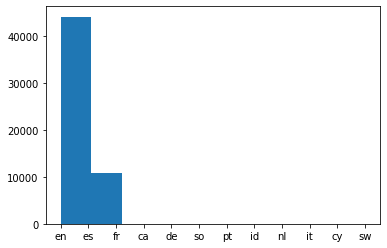

In [ ]:
plt.hist(all_dataset.language)

In [ ]:
def get_subpillar_datasets (subpillar_name:str, dataset, perform_augmentation:bool=True, n_times=1):
    """
    1) keep rows where the sub-pillar name is contained in the column 'subpillars'
    2) keep only subpillar names in the column 'subpillar' (omit pillar name)
    """
    df = dataset[['entry_id', 'excerpt', 'pillars', 'subpillars', 'language']]
    df['subpillars'] = df.subpillars\
                        .apply(lambda x: list(filter(lambda y: subpillar_name in y, x)))\
                        .apply(lambda x: [y.split('->')[1] for y in (x)])

    df = df[df.subpillars.apply(lambda x: len(x)>0)]
    
    if perform_augmentation:
        train_data, test_data = train_test_split(df, test_size=0.3)
        return augment_data(train_data, n_times), test_data
    else: 
        return train_test_split(df, test_size=0.2)

In [ ]:
def augment_data (df, n_times):
    en_tmp = df[df.language=='en']
    fr_tmp = df[df.language=='fr']
    es_tmp = df[df.language=='es']
    
    syn_aug_en = naw.SynonymAug(lang='eng', aug_min=3, aug_p=0.4)
    syn_aug_fr = naw.SynonymAug(lang='fra', aug_min=3, aug_p=0.4)
    syn_aug_es = naw.SynonymAug(lang='spa', aug_min=3, aug_p=0.4)

    """context_aug = naw.ContextualWordEmbsAug(
        model_path='squeezebert/squeezebert-uncased',
        device='cuda')

    aug_trans_en = naw.BackTranslationAug(
        from_model_name='facebook/wmt19-en-ru', 
        to_model_name='facebook/wmt19-ru-en',
        device='cuda'
    )
    aug_trans_fr = naw.BackTranslationAug(
        from_model_name='Helsinki-NLP/opus-mt-fr-ru', 
        to_model_name='Helsinki-NLP/opus-mt-ru-fr',
        device='cuda'
    )
    aug_trans_es = naw.BackTranslationAug(
        from_model_name='Helsinki-NLP/opus-mt-es-ru', 
        to_model_name='Helsinki-NLP/opus-mt-ru-es',
        device='cuda'
    )
    #device='cuda'
    en_trans_word = en_tmp
    fr_trans_word = fr_tmp
    es_trans_word = es_tmp
    en_context_word = en_tmp"""

    en_tmp.excerpt = en_tmp.excerpt.apply(lambda x: syn_aug_en.augment(x, n=n_times))
    fr_tmp.excerpt = fr_tmp.excerpt.apply(lambda x: syn_aug_fr.augment(x, n=n_times))
    es_tmp.excerpt = es_tmp.excerpt.apply(lambda x: syn_aug_es.augment(x, n=n_times))

    #en_context_word.excerpt = en_context_word.excerpt.apply(lambda x: context_aug.augment(x, n=n_times))

    """en_trans_word.excerpt = en_trans_word.excerpt.apply(lambda x: aug_trans_en.augment(x, n=n_times))
    fr_trans_word.excerpt = fr_trans_word.excerpt.apply(lambda x: aug_trans_fr.augment(x, n=n_times))
    es_trans_word.excerpt = es_trans_word.excerpt.apply(lambda x: aug_trans_es.augment(x, n=n_times))"""

    whole_df_tmp = pd.concat([en_tmp, fr_tmp, es_tmp])
     
    for _, row in whole_df_tmp.iterrows():
        excerpts = row.excerpt
        for i in range (0,n_times):
            row.excerpt = excerpts[i]
            df = df.append(row)
    return df

In [ ]:
capacities_response_train_dataset, capacities_response_val_dataset =\
                get_subpillar_datasets ('Capacities & Response', 
                                        all_dataset,
                                       n_times=2)

hum_conditions_train_dataset, hum_conditions_val_dataset =\
                get_subpillar_datasets ('Humanitarian Conditions', 
                                        all_dataset,
                                       perform_augmentation=False)

impact_train_dataset, impact_val_dataset = get_subpillar_datasets ('Impact', 
                                                                   all_dataset,
                                                                  perform_augmentation=False)

people_at_risk_train_dataset, people_at_risk_val_dataset = get_subpillar_datasets ('People At Risk',
                                                                                   all_dataset,
                                                                                  n_times=2)

priority_interventions_train_dataset, priority_interventions_val_dataset = \
                get_subpillar_datasets ('Priority Interventions', 
                                        all_dataset,
                                       n_times=3)

priority_needs_train_dataset, priority_needs_val_dataset = get_subpillar_datasets ('Priority Needs', 
                                                                                   all_dataset, 
                                                                                   n_times=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
print('number of rows for capacities & response :', capacities_response_train_dataset.shape[0])
print('number of rows for Humanitarian Conditions:', hum_conditions_train_dataset.shape[0])
print('number of rows for Impact :', impact_train_dataset.shape[0])
print('number of rows for People At Risk :', people_at_risk_train_dataset.shape[0])
print('number of rows for Priority Interventions :', priority_interventions_train_dataset.shape[0])
print('number of rows for Priority Needs :', priority_needs_train_dataset.shape[0])

number of rows for capacities & response : 20419
number of rows for Humanitarian Conditions: 23636
number of rows for Impact : 17136
number of rows for People At Risk : 15671
number of rows for Priority Interventions : 4704
number of rows for Priority Needs : 5679


In [ ]:
impact_train_dataset.head()

,entry_id,excerpt,target,language
66185,220079,"Au secteur 6 de la commune de Banzon, le comit...",[Driver/Aggravating Factors],fr
1056,166899,"Trinidad and Tobago, along with other Eastern ...",[Driver/Aggravating Factors],en
856,159577,"So far, 12,671 HH have been affected by floodi...","[Number Of People Affected, Impact On Systems ...",en
71,163885,• En Nariño y Chocó las fuertes inundaciones h...,"[Impact On People Or Impact On Services, Drive...",es
46616,325323,"[4th-10th April 2021, Cox's Bazar] Both Refuge...",[Impact On People],en


In [ ]:
tot_train = pd.concat([capacities_response_train_dataset,
                       hum_conditions_train_dataset,
                       impact_train_dataset,
                       people_at_risk_train_dataset,
                       priority_interventions_train_dataset,
                       priority_needs_train_dataset])[['entry_id', 'excerpt', 'pillars']].rename(columns={'pillars': 'target'})

tot_test = pd.concat([capacities_response_val_dataset,
                       hum_conditions_val_dataset,
                       impact_val_dataset,
                       people_at_risk_val_dataset,
                       priority_interventions_val_dataset,
                       priority_needs_val_dataset])[['entry_id', 'excerpt', 'pillars']].rename(columns={'pillars': 'target'})

tot_train.to_csv('augmented_train.csv')
tot_test.to_csv('augmented_test.csv')

In [ ]:
cd 'data'

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
capacities_response_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('capacities_response_train_dataset.csv')
capacities_response_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('capacities_response_val_dataset.csv')

hum_conditions_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('hum_conditions_train_dataset.csv')
hum_conditions_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('hum_conditions_val_dataset.csv')

impact_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('impact_train_dataset.csv')
impact_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('impact_val_dataset.csv')

people_at_risk_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('people_at_risk_train_dataset.csv')
people_at_risk_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('people_at_risk_val_dataset.csv')

priority_interventions_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('priority_interventions_train_dataset.csv')
priority_interventions_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('priority_interventions_val_dataset.csv')

priority_needs_train_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('priority_needs_train_dataset.csv')
priority_needs_val_dataset[['entry_id', 'excerpt', 'subpillars']].rename(columns={'subpillars': 'target'}).to_csv('priority_needs_val_dataset.csv')

1) Priority needs and interventions too underrepresented, better to change it  
2) Impact, there is an overlap, what to do?  
3) Dataset augmentation that depends on pretrained models (back-translation, context augmentation takes too long, I prefferend to stick with basic nltk libraries)